**Fake News Detection**

It has become humanly impossible to identify fake news on the online portals across the globe.The sheer volume and the pace at which news spreads calls the need to create a ML model to classify the fake from true news.

The most crucial thing here is data which has been already available in the kaggle. We will be using different methods and compare the results.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


**Import the data & Clean ups**

In [3]:
#importing data
fake_data = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
print("fake_data",fake_data.shape)

true_data= pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
print("true_data",true_data.shape)

fake_data (23481, 4)
true_data (21417, 4)


In [4]:
fake_data.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true_data.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
#adding additonal column to seperate betwee true & fake data
# true =1, fake =0
true_data['target'] = 1
fake_data['target'] = 0
df = pd.concat([true_data, fake_data]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


In [7]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

**Data Clean up**
- create a function here that will be responsible to remove any unneccesary words (Stopwords) from the data provided

In [8]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [9]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

In [10]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=350)
fig.show()

- The data looks balanced and no issues on building the model

In [11]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

In [12]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [13]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

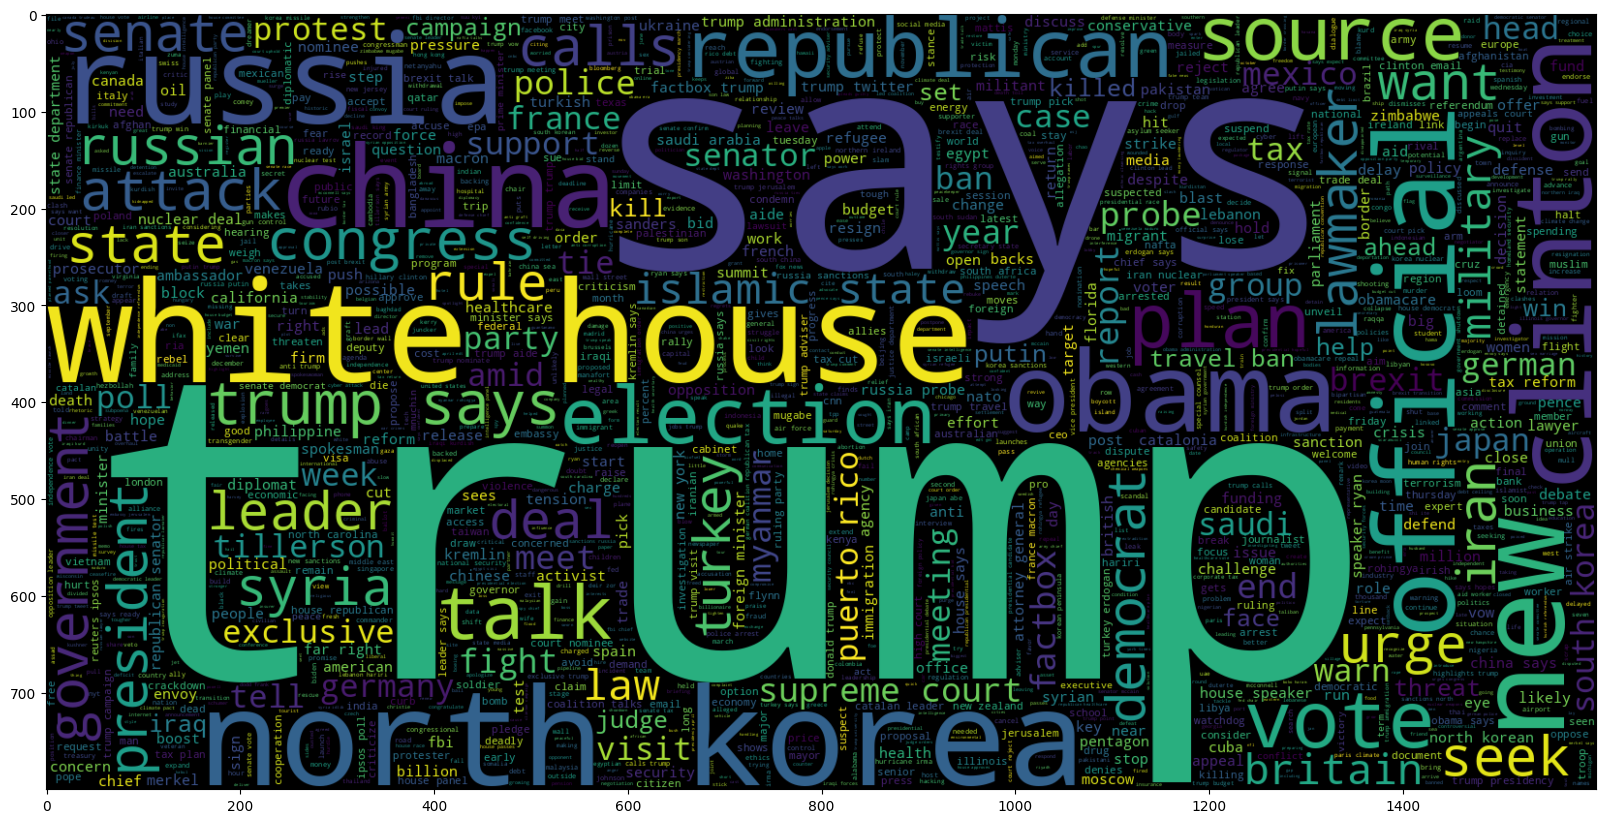

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

In [15]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

The maximum number of words in a title is = 34


**Creating Prediction Model**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [17]:
#model 
model = LogisticRegression(C=2)

#fit the model
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)

#accuracy & predicted value
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9475943910154114


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Create the confusion matrix**

<Axes: >

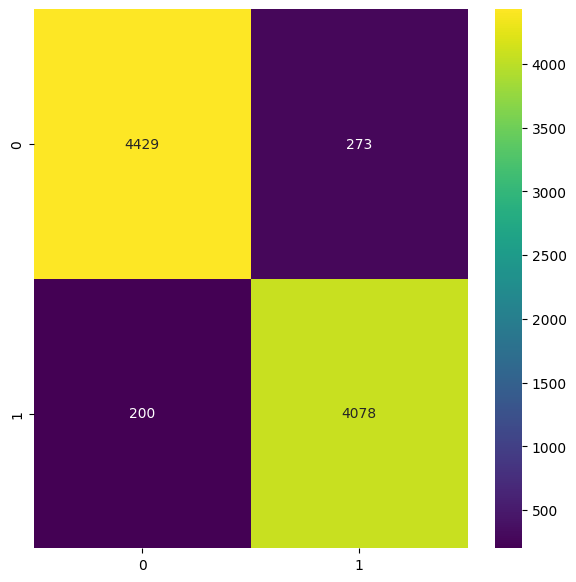

In [18]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

- 4465 Fake News have been Classified as Fake
- 4045 Real News have been classified as Real

**Checking the content of news**

In [19]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

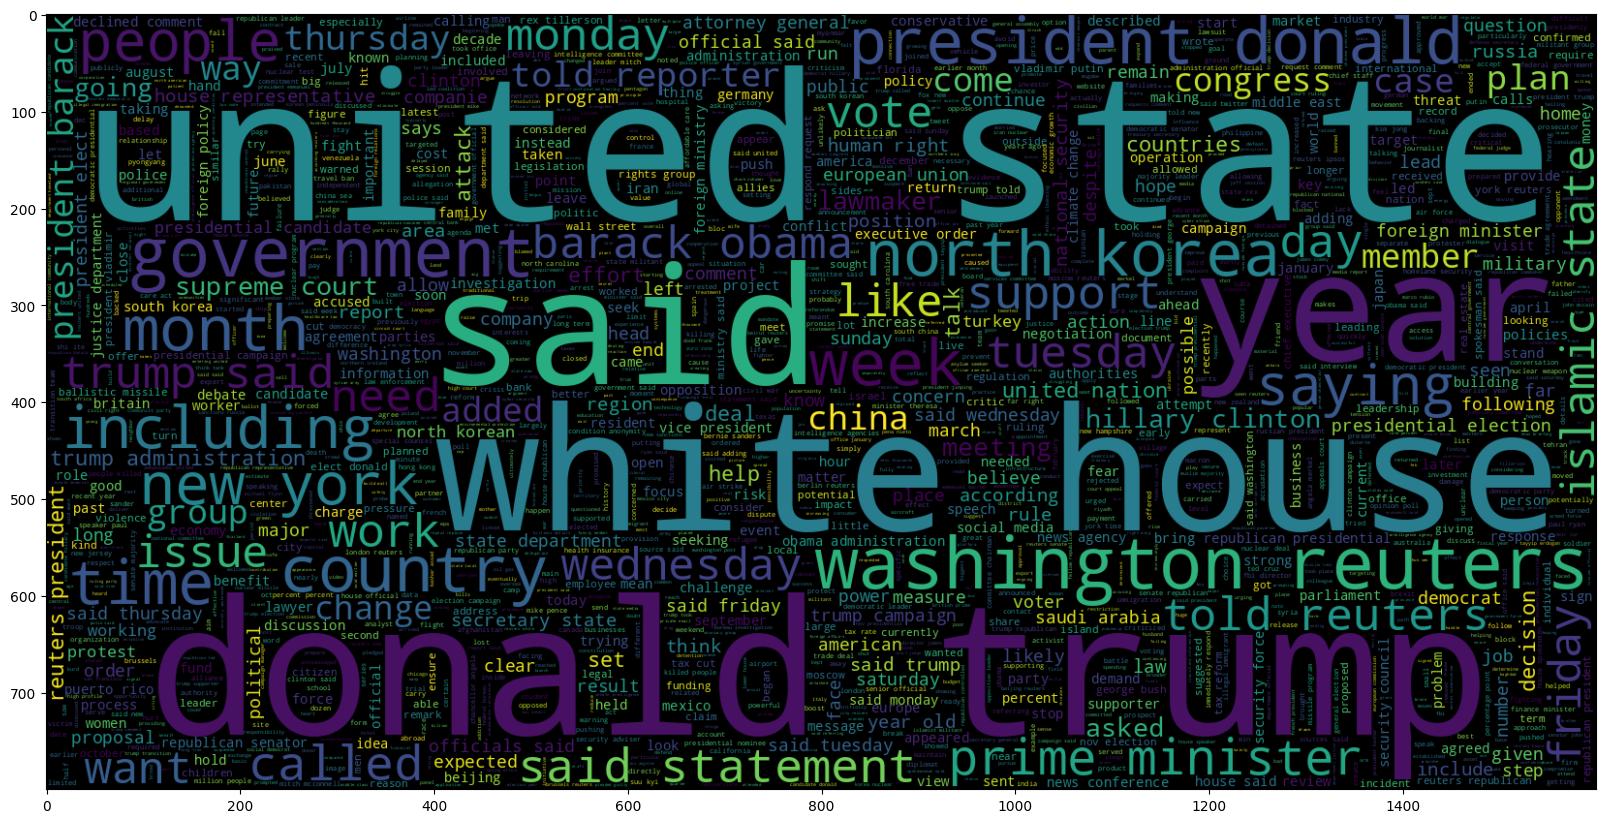

In [20]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

In [21]:
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()


The maximum number of words in a News Content is = 4573


**Predicting the Model**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9953661308915527


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



<Axes: >

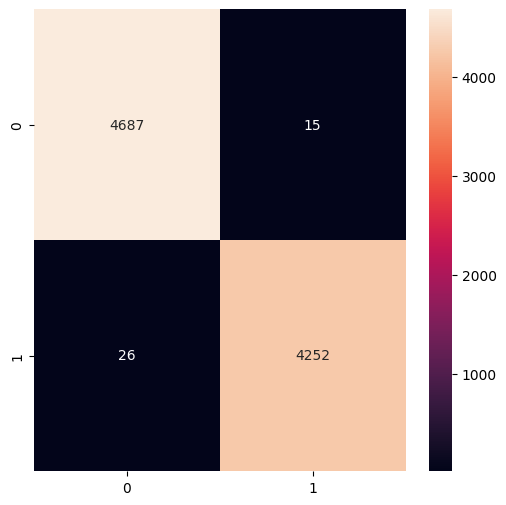

In [23]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True,fmt='g')